In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs

import tensorflow as tf
import tensorflow_addons as tfa
AUTOTUNE = tf.data.AUTOTUNE
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

tf.__version__

'2.5.0'

In [2]:
tf.random.set_seed(1234)

In [3]:
in_path = './test/*'

In [4]:
img_files = list(glob.glob(in_path))
len(img_files)

6

In [5]:
raw_test_ds = tf.data.Dataset.from_tensor_slices(img_files)

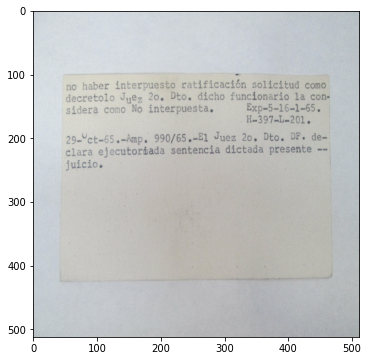

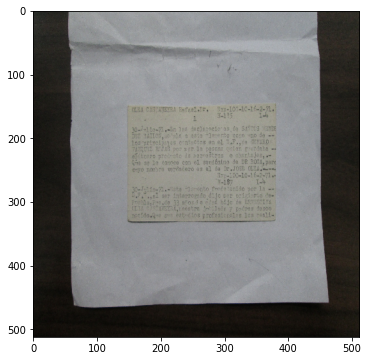

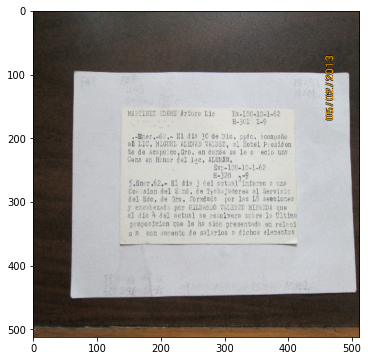

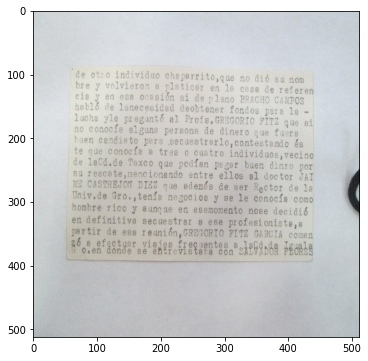

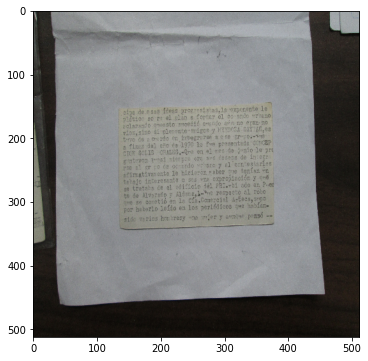

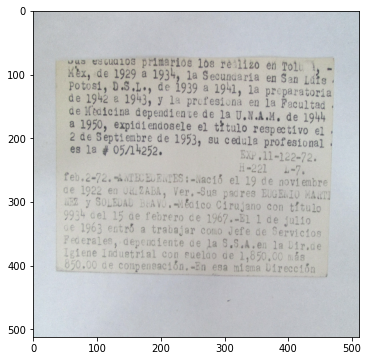

In [8]:
def convert(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [512, 512])
    return img

batch_size = 1
test_batches = raw_test_ds.map(convert, 
                               num_parallel_calls=AUTOTUNE).batch(batch_size, 
                                              num_parallel_calls=AUTOTUNE)

for i in test_batches:
    i = tf.cast(i, tf.uint8)
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(i[0])

In [7]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import activations

class CNN(tf.keras.models.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.aug = tf.keras.Sequential([
            layers.experimental.preprocessing.RandomContrast(0.9),
            layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
            
        ])
        self.conv_1 = tf.keras.Sequential([
            layers.Conv2D(32, kernel_size=5, 
                          strides=1, padding='same'),
            layers.Activation(activations.relu),
            layers.Conv2D(32, kernel_size=5, 
                          strides=1, padding='same'),
        ])
        self.res_1 = layers.Conv2D(32, kernel_size=1, strides=1, padding='same')
        
        self.conv_2 = tf.keras.Sequential([
            layers.Conv2D(64, kernel_size=3,
                          strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activations.relu),
            layers.Conv2D(64, kernel_size=3,
                          strides=1, padding='same'),
            layers.BatchNormalization(),
        ])
        self.res_2 = layers.Conv2D(64, kernel_size=1, strides=2, padding='same')

        
        self.conv_3 = tf.keras.Sequential([
            layers.Conv2D(64, kernel_size=3,
                          strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Activation(activations.relu),
            layers.Conv2D(64, kernel_size=3,
                          strides=1, padding='same'),
            layers.BatchNormalization(),
        ])
        self.res_3 = layers.Conv2D(64, kernel_size=1, strides=2, padding='same')
        self.flat = tf.keras.layers.GlobalAveragePooling2D()

        self.angle = tf.keras.Sequential([
            layers.Dense(32),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Dense(4, activation='softmax')
        ])
    
    def call(self, inp, training=False):
        x = self.aug(inp, training=training)
        skip_1 = self.res_1(x, training=training)
        x = tf.nn.relu(self.conv_1(x, training=training) + skip_1)
        skip_2 = self.res_2(x, training=training)
        x = tf.nn.relu(self.conv_2(x, training=training) + skip_2)
        skip_3 = self.res_3(x, training=training)
        x = tf.nn.relu(self.conv_3(x, training=training) + skip_3)
        x = self.flat(x, training=training)
        x = self.angle(x, training=training)
        return x
    
model = CNN()


In [8]:
tf.keras.models.load_model('./mymodel_620/')

In [9]:
out_path = './out/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [10]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

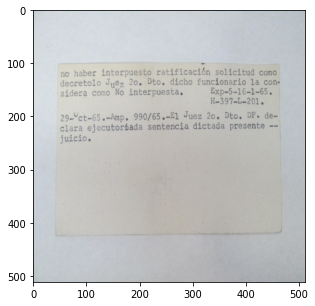

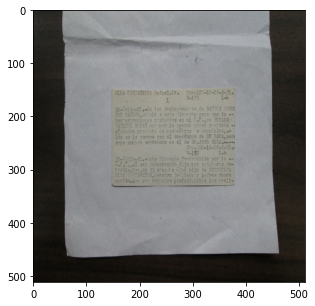

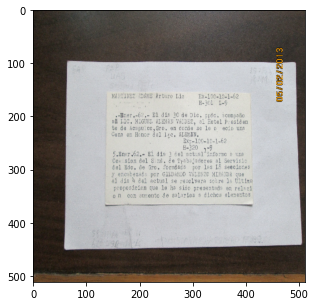

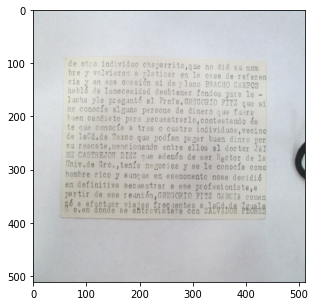

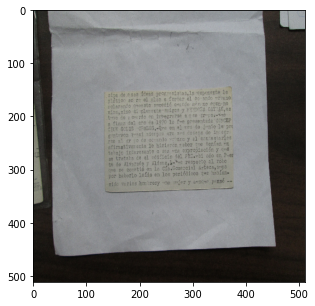

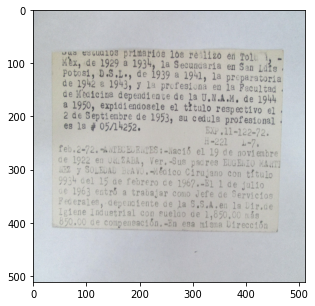

In [11]:
for i, img in enumerate(test_batches):
    angle = model(img, training=False)
    angle = tf.cast(tf.math.argmax(angle, axis=1), tf.int32)
    correct_img = tf.image.rot90(img, k=angle[0] - 1)
    correct_img = tensor_to_image(correct_img)
    save_path = os.path.join(out_path, str(i))
    correct_img.save(save_path + '.jpeg')

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(correct_img)